# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [ ]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

In [1]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [2]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [3]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(brightness=0.5, hue=0.3),
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [4]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:47<00:00,  1.86it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [5]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list(set([annot[1] for annot in annotations])))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image =  tiny_img_dataset.read_rgb_image(img_name)

            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [6]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:13<00:00, 760.49it/s]


For the most cases the default `DataLoader` will be good enough.

In [8]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

In [9]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=4)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [13]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(f'convbnrelu_{block_index}_{layer_index_in_block}', ConvBNRelu(in_channels, out_channels))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [14]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [15]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [16]:
opt = torch.optim.Adam(model.parameters())

### 1.5 Training loop

Let's combine the previously defined things together.

In [19]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [20]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]


Epoch 1 of 30 took 80.654s
  training loss (in-iteration): 	4.489927
  validation accuracy: 			11.44 %


100%|██████████| 1563/1563 [01:16<00:00, 20.51it/s]


Epoch 2 of 30 took 77.499s
  training loss (in-iteration): 	3.833613
  validation accuracy: 			19.20 %


100%|██████████| 1563/1563 [01:16<00:00, 20.38it/s]


Epoch 3 of 30 took 77.967s
  training loss (in-iteration): 	3.497215
  validation accuracy: 			22.93 %


100%|██████████| 1563/1563 [01:15<00:00, 20.66it/s]


Epoch 4 of 30 took 76.964s
  training loss (in-iteration): 	3.283700
  validation accuracy: 			26.32 %


100%|██████████| 1563/1563 [01:16<00:00, 20.41it/s]


Epoch 5 of 30 took 77.875s
  training loss (in-iteration): 	3.123388
  validation accuracy: 			26.00 %


100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


Epoch 6 of 30 took 77.617s
  training loss (in-iteration): 	3.003039
  validation accuracy: 			25.59 %


100%|██████████| 1563/1563 [01:15<00:00, 20.60it/s]


Epoch 7 of 30 took 77.123s
  training loss (in-iteration): 	2.899057
  validation accuracy: 			32.21 %


100%|██████████| 1563/1563 [01:15<00:00, 20.60it/s]


Epoch 8 of 30 took 77.131s
  training loss (in-iteration): 	2.811091
  validation accuracy: 			32.59 %


100%|██████████| 1563/1563 [01:16<00:00, 20.51it/s]


Epoch 9 of 30 took 77.489s
  training loss (in-iteration): 	2.738836
  validation accuracy: 			33.51 %


100%|██████████| 1563/1563 [01:16<00:00, 20.46it/s]


Epoch 10 of 30 took 77.684s
  training loss (in-iteration): 	2.676182
  validation accuracy: 			34.84 %


100%|██████████| 1563/1563 [01:16<00:00, 20.43it/s]


Epoch 11 of 30 took 77.824s
  training loss (in-iteration): 	2.624650
  validation accuracy: 			35.66 %


100%|██████████| 1563/1563 [01:15<00:00, 20.70it/s]


Epoch 12 of 30 took 76.786s
  training loss (in-iteration): 	2.572956
  validation accuracy: 			36.31 %


100%|██████████| 1563/1563 [01:16<00:00, 20.37it/s]


Epoch 13 of 30 took 78.026s
  training loss (in-iteration): 	2.529420
  validation accuracy: 			36.41 %


100%|██████████| 1563/1563 [01:17<00:00, 20.09it/s]


Epoch 14 of 30 took 79.118s
  training loss (in-iteration): 	2.491237
  validation accuracy: 			38.68 %


100%|██████████| 1563/1563 [01:18<00:00, 19.84it/s]


Epoch 15 of 30 took 80.081s
  training loss (in-iteration): 	2.458107
  validation accuracy: 			38.69 %


100%|██████████| 1563/1563 [01:18<00:00, 20.01it/s]


Epoch 16 of 30 took 79.409s
  training loss (in-iteration): 	2.424989
  validation accuracy: 			37.90 %


100%|██████████| 1563/1563 [01:18<00:00, 19.83it/s]


Epoch 17 of 30 took 80.137s
  training loss (in-iteration): 	2.389463
  validation accuracy: 			37.60 %


100%|██████████| 1563/1563 [01:17<00:00, 20.13it/s]


Epoch 18 of 30 took 78.938s
  training loss (in-iteration): 	2.361868
  validation accuracy: 			38.70 %


100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


Epoch 19 of 30 took 78.165s
  training loss (in-iteration): 	2.340465
  validation accuracy: 			39.04 %


100%|██████████| 1563/1563 [01:17<00:00, 20.16it/s]


Epoch 20 of 30 took 78.826s
  training loss (in-iteration): 	2.312136
  validation accuracy: 			39.31 %


100%|██████████| 1563/1563 [01:17<00:00, 20.26it/s]


Epoch 21 of 30 took 78.480s
  training loss (in-iteration): 	2.286877
  validation accuracy: 			39.33 %


100%|██████████| 1563/1563 [01:18<00:00, 19.96it/s]


Epoch 22 of 30 took 79.643s
  training loss (in-iteration): 	2.265254
  validation accuracy: 			39.07 %


100%|██████████| 1563/1563 [01:18<00:00, 19.85it/s]


Epoch 23 of 30 took 80.079s
  training loss (in-iteration): 	2.246756
  validation accuracy: 			38.99 %


100%|██████████| 1563/1563 [01:18<00:00, 19.86it/s]


Epoch 24 of 30 took 80.043s
  training loss (in-iteration): 	2.226990
  validation accuracy: 			39.86 %


100%|██████████| 1563/1563 [01:18<00:00, 19.88it/s]


Epoch 25 of 30 took 79.945s
  training loss (in-iteration): 	2.210491
  validation accuracy: 			40.32 %


100%|██████████| 1563/1563 [01:18<00:00, 19.83it/s]


Epoch 26 of 30 took 80.144s
  training loss (in-iteration): 	2.196244
  validation accuracy: 			41.08 %


100%|██████████| 1563/1563 [01:17<00:00, 20.08it/s]


Epoch 27 of 30 took 79.143s
  training loss (in-iteration): 	2.171698
  validation accuracy: 			40.66 %


100%|██████████| 1563/1563 [01:16<00:00, 20.46it/s]


Epoch 28 of 30 took 77.688s
  training loss (in-iteration): 	2.158861
  validation accuracy: 			40.62 %


100%|██████████| 1563/1563 [01:16<00:00, 20.41it/s]


Epoch 29 of 30 took 77.858s
  training loss (in-iteration): 	2.143645
  validation accuracy: 			39.81 %


100%|██████████| 1563/1563 [01:16<00:00, 20.54it/s]


Epoch 30 of 30 took 77.386s
  training loss (in-iteration): 	2.123657
  validation accuracy: 			40.92 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [21]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        
        residual = self.conv2(residual)
        residual = self.bn2(residual)     
        
        if self.conv3 is not None:
            x = self.conv3(x)
            
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f'resblock_{in_channels}_{out_channels}', ResNetBlock2(in_channels, out_channels))
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [22]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:29<00:00, 17.51it/s]


Epoch 1 of 30 took 92.544s
  training loss (in-iteration): 	4.934223
  validation accuracy: 			4.17 %


100%|██████████| 1563/1563 [01:29<00:00, 17.41it/s]


Epoch 2 of 30 took 93.013s
  training loss (in-iteration): 	4.395395
  validation accuracy: 			11.39 %


100%|██████████| 1563/1563 [01:29<00:00, 17.45it/s]


Epoch 3 of 30 took 92.827s
  training loss (in-iteration): 	4.019716
  validation accuracy: 			15.79 %


100%|██████████| 1563/1563 [01:29<00:00, 17.48it/s]


Epoch 4 of 30 took 92.663s
  training loss (in-iteration): 	3.757593
  validation accuracy: 			19.10 %


100%|██████████| 1563/1563 [01:29<00:00, 17.44it/s]


Epoch 5 of 30 took 92.838s
  training loss (in-iteration): 	3.553893
  validation accuracy: 			21.40 %


100%|██████████| 1563/1563 [01:29<00:00, 17.37it/s]


Epoch 6 of 30 took 93.240s
  training loss (in-iteration): 	3.397716
  validation accuracy: 			24.00 %


100%|██████████| 1563/1563 [01:29<00:00, 17.38it/s]


Epoch 7 of 30 took 93.177s
  training loss (in-iteration): 	3.267986
  validation accuracy: 			25.28 %


100%|██████████| 1563/1563 [01:29<00:00, 17.47it/s]


Epoch 8 of 30 took 92.710s
  training loss (in-iteration): 	3.160603
  validation accuracy: 			27.07 %


100%|██████████| 1563/1563 [01:31<00:00, 17.17it/s]


Epoch 9 of 30 took 94.305s
  training loss (in-iteration): 	3.065140
  validation accuracy: 			29.45 %


100%|██████████| 1563/1563 [01:31<00:00, 17.12it/s]


Epoch 10 of 30 took 94.575s
  training loss (in-iteration): 	2.981769
  validation accuracy: 			30.28 %


100%|██████████| 1563/1563 [01:30<00:00, 17.20it/s]


Epoch 11 of 30 took 94.126s
  training loss (in-iteration): 	2.907453
  validation accuracy: 			31.03 %


100%|██████████| 1563/1563 [01:31<00:00, 17.10it/s]


Epoch 12 of 30 took 94.649s
  training loss (in-iteration): 	2.849674
  validation accuracy: 			32.32 %


100%|██████████| 1563/1563 [01:30<00:00, 17.21it/s]


Epoch 13 of 30 took 94.092s
  training loss (in-iteration): 	2.787894
  validation accuracy: 			33.23 %


100%|██████████| 1563/1563 [01:30<00:00, 17.24it/s]


Epoch 14 of 30 took 93.890s
  training loss (in-iteration): 	2.731796
  validation accuracy: 			34.04 %


100%|██████████| 1563/1563 [01:30<00:00, 17.21it/s]


Epoch 15 of 30 took 94.084s
  training loss (in-iteration): 	2.688369
  validation accuracy: 			35.54 %


100%|██████████| 1563/1563 [01:31<00:00, 17.15it/s]


Epoch 16 of 30 took 94.372s
  training loss (in-iteration): 	2.644931
  validation accuracy: 			37.02 %


100%|██████████| 1563/1563 [01:31<00:00, 17.17it/s]


Epoch 17 of 30 took 94.303s
  training loss (in-iteration): 	2.597545
  validation accuracy: 			37.21 %


100%|██████████| 1563/1563 [01:30<00:00, 17.19it/s]


Epoch 18 of 30 took 94.201s
  training loss (in-iteration): 	2.563125
  validation accuracy: 			37.95 %


100%|██████████| 1563/1563 [01:30<00:00, 17.20it/s]


Epoch 19 of 30 took 94.135s
  training loss (in-iteration): 	2.527030
  validation accuracy: 			37.88 %


100%|██████████| 1563/1563 [01:31<00:00, 17.15it/s]


Epoch 20 of 30 took 94.392s
  training loss (in-iteration): 	2.497953
  validation accuracy: 			37.68 %


100%|██████████| 1563/1563 [01:31<00:00, 17.17it/s]


Epoch 21 of 30 took 94.285s
  training loss (in-iteration): 	2.460232
  validation accuracy: 			38.88 %


100%|██████████| 1563/1563 [01:31<00:00, 17.14it/s]


Epoch 22 of 30 took 94.474s
  training loss (in-iteration): 	2.436424
  validation accuracy: 			37.94 %


100%|██████████| 1563/1563 [01:31<00:00, 17.15it/s]


Epoch 23 of 30 took 94.426s
  training loss (in-iteration): 	2.406833
  validation accuracy: 			38.45 %


100%|██████████| 1563/1563 [01:31<00:00, 17.10it/s]


Epoch 24 of 30 took 94.675s
  training loss (in-iteration): 	2.380782
  validation accuracy: 			37.86 %


100%|██████████| 1563/1563 [01:31<00:00, 17.13it/s]


Epoch 25 of 30 took 94.496s
  training loss (in-iteration): 	2.352897
  validation accuracy: 			39.31 %


100%|██████████| 1563/1563 [01:31<00:00, 17.15it/s]


Epoch 26 of 30 took 94.400s
  training loss (in-iteration): 	2.331478
  validation accuracy: 			40.71 %


100%|██████████| 1563/1563 [01:30<00:00, 17.21it/s]


Epoch 27 of 30 took 94.083s
  training loss (in-iteration): 	2.305165
  validation accuracy: 			40.78 %


100%|██████████| 1563/1563 [01:30<00:00, 17.22it/s]


Epoch 28 of 30 took 94.067s
  training loss (in-iteration): 	2.288226
  validation accuracy: 			40.47 %


100%|██████████| 1563/1563 [01:30<00:00, 17.18it/s]


Epoch 29 of 30 took 94.255s
  training loss (in-iteration): 	2.264594
  validation accuracy: 			40.62 %


100%|██████████| 1563/1563 [01:30<00:00, 17.22it/s]


Epoch 30 of 30 took 94.011s
  training loss (in-iteration): 	2.241976
  validation accuracy: 			42.04 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [ ]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


Epoch 1 of 30 took 81.822s
  training loss (in-iteration): 	4.808314
  validation accuracy: 			6.03 %


100%|██████████| 1563/1563 [01:19<00:00, 19.61it/s]


Epoch 2 of 30 took 81.275s
  training loss (in-iteration): 	4.296267
  validation accuracy: 			9.50 %


100%|██████████| 1563/1563 [01:19<00:00, 19.57it/s]


Epoch 3 of 30 took 81.446s
  training loss (in-iteration): 	3.951730
  validation accuracy: 			13.91 %


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


Epoch 4 of 30 took 81.575s
  training loss (in-iteration): 	3.689614
  validation accuracy: 			16.45 %


100%|██████████| 1563/1563 [01:19<00:00, 19.59it/s]


Epoch 5 of 30 took 81.369s
  training loss (in-iteration): 	3.501095
  validation accuracy: 			20.67 %


100%|██████████| 1563/1563 [01:19<00:00, 19.61it/s]


Epoch 6 of 30 took 81.236s
  training loss (in-iteration): 	3.343567
  validation accuracy: 			23.89 %


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]


Epoch 7 of 30 took 80.799s
  training loss (in-iteration): 	3.215247
  validation accuracy: 			24.55 %


100%|██████████| 1563/1563 [01:20<00:00, 19.49it/s]


Epoch 8 of 30 took 81.741s
  training loss (in-iteration): 	3.097966
  validation accuracy: 			27.38 %


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


Epoch 9 of 30 took 81.563s
  training loss (in-iteration): 	2.994309
  validation accuracy: 			30.20 %


100%|██████████| 1563/1563 [01:19<00:00, 19.70it/s]


Epoch 10 of 30 took 80.871s
  training loss (in-iteration): 	2.901921
  validation accuracy: 			30.24 %


100%|██████████| 1563/1563 [01:19<00:00, 19.54it/s]


Epoch 11 of 30 took 81.546s
  training loss (in-iteration): 	2.811374
  validation accuracy: 			32.07 %


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]


Epoch 12 of 30 took 80.863s
  training loss (in-iteration): 	2.736786
  validation accuracy: 			31.64 %


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


Epoch 13 of 30 took 81.600s
  training loss (in-iteration): 	2.664629
  validation accuracy: 			34.21 %


100%|██████████| 1563/1563 [01:20<00:00, 19.53it/s]


Epoch 14 of 30 took 81.608s
  training loss (in-iteration): 	2.609828
  validation accuracy: 			34.51 %


100%|██████████| 1563/1563 [01:19<00:00, 19.66it/s]


Epoch 15 of 30 took 81.072s
  training loss (in-iteration): 	2.545612
  validation accuracy: 			35.08 %


100%|██████████| 1563/1563 [01:19<00:00, 19.62it/s]


Epoch 16 of 30 took 81.194s
  training loss (in-iteration): 	2.494682
  validation accuracy: 			36.31 %


100%|██████████| 1563/1563 [01:19<00:00, 19.65it/s]


Epoch 17 of 30 took 81.108s
  training loss (in-iteration): 	2.449155
  validation accuracy: 			36.44 %


100%|██████████| 1563/1563 [01:19<00:00, 19.73it/s]


Epoch 18 of 30 took 80.770s
  training loss (in-iteration): 	2.403383
  validation accuracy: 			38.28 %


100%|██████████| 1563/1563 [01:19<00:00, 19.69it/s]


Epoch 19 of 30 took 80.946s
  training loss (in-iteration): 	2.355536
  validation accuracy: 			37.11 %


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]


Epoch 20 of 30 took 80.843s
  training loss (in-iteration): 	2.315961
  validation accuracy: 			39.22 %


100%|██████████| 1563/1563 [01:19<00:00, 19.71it/s]


Epoch 21 of 30 took 80.875s
  training loss (in-iteration): 	2.277346
  validation accuracy: 			37.46 %


100%|██████████| 1563/1563 [01:19<00:00, 19.57it/s]


Epoch 22 of 30 took 81.463s
  training loss (in-iteration): 	2.239124
  validation accuracy: 			39.29 %


100%|██████████| 1563/1563 [01:20<00:00, 19.47it/s]


Epoch 23 of 30 took 81.890s
  training loss (in-iteration): 	2.201872
  validation accuracy: 			39.94 %


100%|██████████| 1563/1563 [01:19<00:00, 19.60it/s]


Epoch 24 of 30 took 81.308s
  training loss (in-iteration): 	2.169313
  validation accuracy: 			39.57 %


100%|██████████| 1563/1563 [01:20<00:00, 19.51it/s]


Epoch 26 of 30 took 81.648s
  training loss (in-iteration): 	2.108906
  validation accuracy: 			40.20 %


100%|██████████| 1563/1563 [01:19<00:00, 19.59it/s]


Epoch 27 of 30 took 81.363s
  training loss (in-iteration): 	2.076427
  validation accuracy: 			40.86 %


100%|██████████| 1563/1563 [01:19<00:00, 19.67it/s]


Epoch 28 of 30 took 81.021s
  training loss (in-iteration): 	2.049875
  validation accuracy: 			39.13 %


100%|██████████| 1563/1563 [01:19<00:00, 19.62it/s]


Epoch 29 of 30 took 81.226s
  training loss (in-iteration): 	2.016979
  validation accuracy: 			40.52 %


100%|██████████| 1563/1563 [01:19<00:00, 19.65it/s]


Epoch 30 of 30 took 81.118s
  training loss (in-iteration): 	1.991434
  validation accuracy: 			40.55 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [24]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.40545382165605093


In [25]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = transformations(X_batch)
                X_batch_transformed = X_batch_transformed.cuda()
                logits = model(X_batch_transformed) 
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.mean(torch.stack(logits_per_transform), dim=0)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [26]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2)
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
])

In [27]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:19<00:00,  8.18it/s]


Model accuracy with 3 forward runs is 0.4166003184713376


100%|██████████| 157/157 [00:29<00:00,  5.34it/s]


Model accuracy with 5 forward runs is 0.4166998407643312


100%|██████████| 157/157 [00:40<00:00,  3.90it/s]


Model accuracy with 7 forward runs is 0.42167595541401276


100%|██████████| 157/157 [00:51<00:00,  3.05it/s]


Model accuracy with 9 forward runs is 0.42197452229299365


100%|██████████| 157/157 [01:11<00:00,  2.19it/s]


Model accuracy with 13 forward runs is 0.4198845541401274


100%|██████████| 157/157 [01:22<00:00,  1.89it/s]

Model accuracy with 15 forward runs is 0.4239649681528662


Let's visualize what we have computed

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

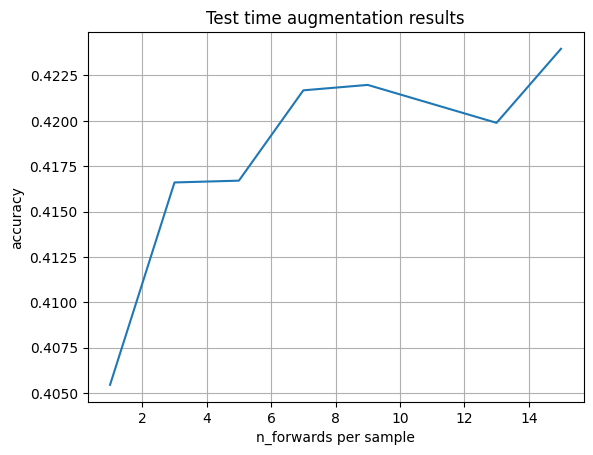

In [29]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape